In [38]:
import os

import corner
import matplotlib.pyplot as plt
import numpy as np

from starcluster.extract_data import Data
from starcluster.utils import ExpectedValues

from corner import corner as crn
from figaro.mixture import DPGMM
from figaro.utils import get_priors, plot_multidim
from pathlib import Path

n_alot = 10000

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Pleiades - Astrometry

In [39]:
data_path = Path(os.getcwd()).joinpath('data/Pleiades-DR3.csv')
#outpath = Path(os.getcwd()).joinpath('data/pleiades-hdf5-test.hdf5')
outpath = 'data/Pleiades-DR3.hdf5'

# data from SIMBAD - Pleiades
expected = {'ra': 56.6010,
            'dec': +24.1140,
            'l': 166.4628,
            'b': -23.6146,
            'pmra': 19.997,
            'pmdec': -45.548,
            'v_rad': 6.57,
            'plx': 7.364}

expected = ExpectedValues(expected)

plot_title = data_path.parts[-1]
plot_title = plot_title.strip('.csv')
plot_title = plot_title.strip('_gal')
plot_title = plot_title.strip('gaia')

In [40]:
dataset = Data(path=data_path, convert=True)
dataset.save_dataset(name=outpath)

/home/daniele/miniconda3/envs/clusters/lib/python3.7/site-packages/gaiadr3_zeropoint-0.0.4-py3.7.egg/zero_point/zpt.py:208: UserWarning: The apparent magnitude of one or more of the sources is outside the expected range (6-21 mag). 
                Outside this range, there is no further interpolation, thus the values at 6 or 21 are returned.
  UserWarning)
/home/daniele/miniconda3/envs/clusters/lib/python3.7/site-packages/gaiadr3_zeropoint-0.0.4-py3.7.egg/zero_point/zpt.py:236: UserWarning: The pseudocolour of some of the 6p source(s) is outside the expected range (1.24-1.72 mag).
                 The maximum corrections are reached already at 1.24 and 1.72
  UserWarning)


In [58]:
l = dataset('l')
b = dataset('b')
plx = dataset('plx')
pml = dataset('pml_star')
pmb = dataset('pmb')
v_rad = dataset('v_rad')

In [59]:
columns_list = [l, b, plx, pml, pmb, v_rad]

epsilon = 0

bounds = [[l.min() - epsilon, l.max() + epsilon],
          [b.min() - epsilon, b.max() + epsilon],
          [plx.min() - epsilon, plx.max() + epsilon],
          [pml.min() - epsilon, pml.max() + epsilon],
          [pmb.min() - epsilon, pmb.max() + epsilon],
          [v_rad.min() - epsilon, v_rad.max() + epsilon]]

In [60]:
samples = dataset.as_array()

In [61]:
del_idx = []
for idx, data_column in enumerate(columns_list):
    del_idx.append(np.argmin(data_column))
    del_idx.append(np.argmax(data_column))

samples = np.delete(samples, del_idx, axis=0)

In [62]:
prior = get_priors(bounds, samples)

In [63]:
mix = DPGMM(bounds=bounds, prior_pars=prior)

In [64]:
density = mix.density_from_samples(samples)

In [65]:
print(dataset.as_array().shape, density.n_cl)
N_stars = dataset.as_array().shape[0]
print(N_stars)

(5406, 6) 637
5406


### Plot

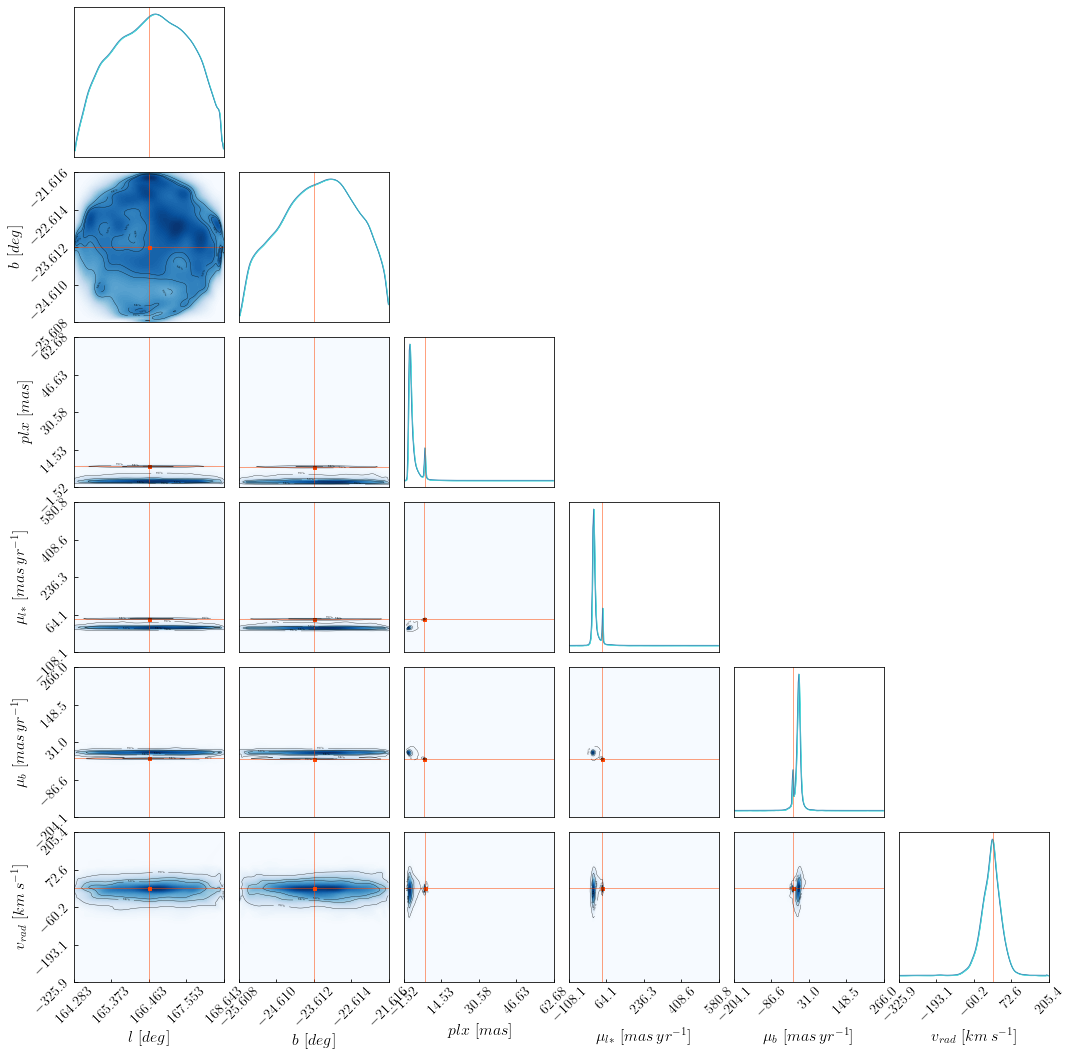

In [66]:
plot_multidim([density],
              out_folder = '.', name = 'density-pleiades',
              labels = [r'l',
                        r'b',
                        r'plx',
                        r'\mu_{l*}',
                        r'\mu_b',
                        r'v_{rad}'],
              units = [r'deg',
                       r'deg',
                       r'mas',
                       r'mas\,yr^{-1}',
                       r'mas\,yr^{-1}',
                       r'km\,s^{-1}'],
              show = True, save = True, subfolder = False,
              n_pts = 200,
              true_value = expected(),
              figsize = 15, levels = [0.5, 0.68, 0.9])

# OLDER - TO BE REFACTORED

## Pleiades - Full photometry

In [2]:
data_path = Path(os.getcwd()).joinpath('data/pleiades-hdf5-test.csv')
#outpath = Path(os.getcwd()).joinpath('data/pleiades-hdf5-test.hdf5')
outpath = 'data/pleiades-hdf5-test.hdf5'

# data from SIMBAD - Pleiades
expected = {'ra': 56.6010,
            'dec': +24.1140,
            'l': 166.4628,
            'b': -23.6146,
            'pmra': 19.997,
            'pmdec': -45.548,
            'v_rad': 6.57,
            'plx': 7.364,
            'g_mag': None,
            'bp_rp': None}

expected = ExpectedValues(expected)

plot_title = data_path.parts[-1]
plot_title = plot_title.strip('.csv')
plot_title = plot_title.strip('_gal')
plot_title = plot_title.strip('gaia')

In [32]:
#std = np.array([0.2, 0.2, 0.05, 2, 2, 0.5, 0.5, 0.1])

std = None
dataset_pleiades, bounds_pleiades, prior_pleiades, mix_pleiades, density_pleiades = dpgmm(data_path,
                                                                                          outpath=outpath,
                                                                                          #convert=False,
                                                                                          std=std,
                                                                                          epsilon=1e-3,
                                                                                          mag='g_mag',
                                                                                          c_index='bp_rp')

In [33]:
print(dataset_pleiades.as_array(mag='g_mag', c_index='bp_rp').shape, density_pleiades.n_cl)
N_stars = dataset_pleiades.as_array(mag='g_mag', c_index='bp_rp').shape[0]

(136, 8) 84


### Plot

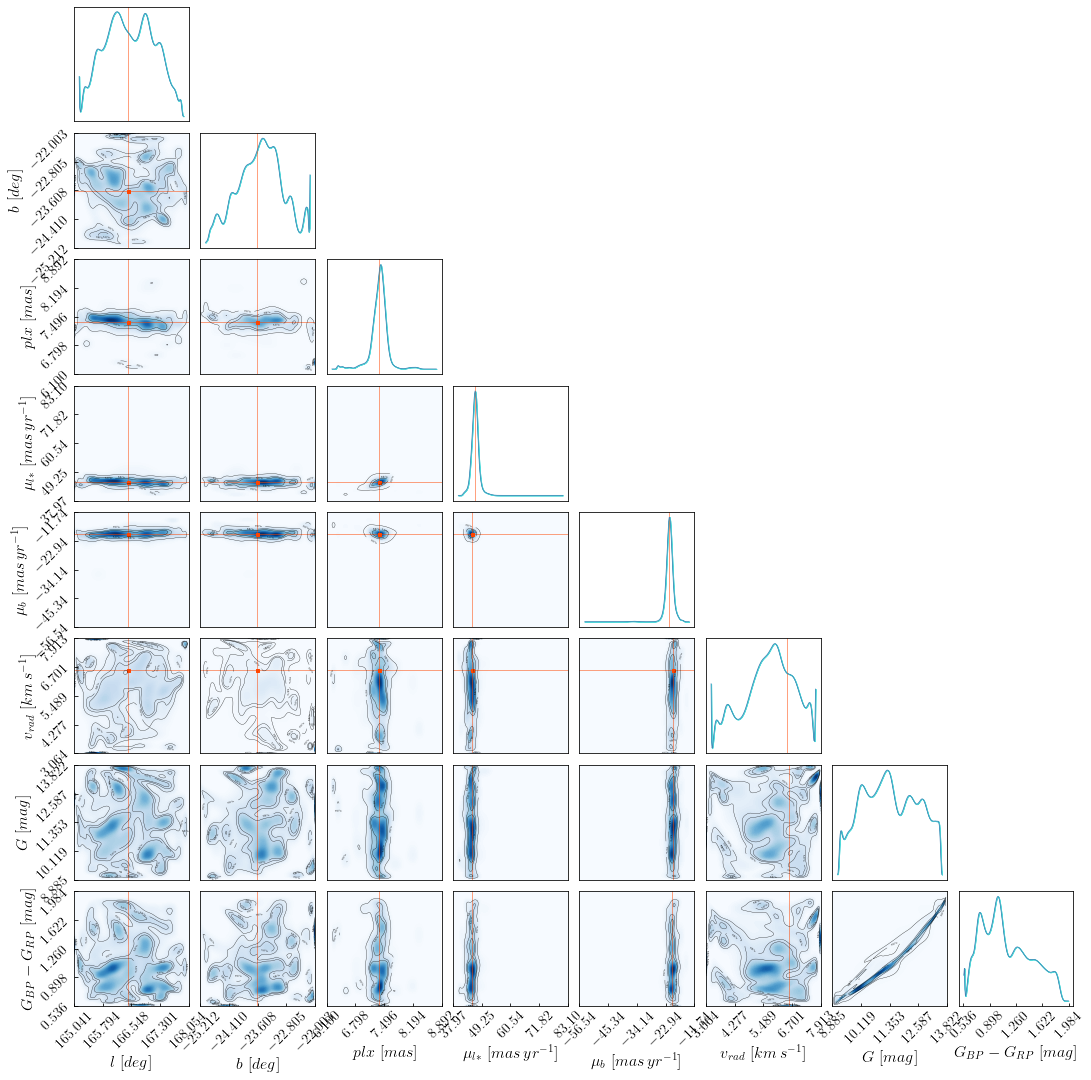

In [34]:
plot_multidim([density_pleiades],
              out_folder = '.', name = 'density-pleiades',
              labels = [r'l',
                        r'b',
                        r'plx',
                        r'\mu_{l*}',
                        r'\mu_b',
                        r'v_{rad}',
                        r'G',
                        r'G_{BP} - G_{RP}'],
              units = [r'deg',
                       r'deg',
                       r'mas',
                       r'mas\,yr^{-1}',
                       r'mas\,yr^{-1}',
                       r'km\,s^{-1}',
                       r'mag',
                       r'mag'],
              show = True, save = True, subfolder = False,
              n_pts = 200,
              true_value = expected(),
              figsize = 15, levels = [0.5, 0.68, 0.9])

In [35]:
dtype = np.dtype([('x', float),
                  ('y', float),
                  ('z', float),
                  ('vx', float),
                  ('vy', float),
                  ('vz', float)])

In [19]:
from starcluster.utils import A_G_INV

# Conversion constant from pc to km (IAU 2015 B2, IAU 2012 B2)
PC2KM = (648000/np.pi) * 149597870.700  # km
# Conversion from pc to kpc
PC2KPC = 1e-3
# Conversion constant from julian yr to seconds.
YR2S = 365.25 * 86400  # s

def __masyr_to_kms(pm, dist):
        pm_asyr = pm * 1e-3  # arcsec/yr
        pm_degyr = pm_asyr / 3600  # deg/yr
        pm_radyr = np.deg2rad(pm_degyr)  # rad/yr
        pm_rads = pm_radyr / YR2S  # rad/s
        distance_km = dist * PC2KM  # km
        pm_kms = pm_rads * distance_km  # km/s
        return pm_kms

def __eq_to_galactic(data):
    ra = np.deg2rad(data['ra'])
    dec = np.deg2rad(data['dec'])
    l = np.deg2rad(data['l'])
    b = np.deg2rad(data['b'])
    distances = 1 / data['parallax']
    pmra = __masyr_to_kms(data['pmra'], distances)  # pm_ra_cosdec
    pmdec = __masyr_to_kms(data['pmdec'], distances)
    # position of star in ICRS cartesian coordinates.
    pos_icrs = np.array([np.cos(dec) * np.cos(ra) * distances,
                         np.cos(dec) * np.sin(ra) * distances,
                         np.sin(dec) * distances])
    pos_icrs *= PC2KPC
    # conversion to galactic coordinates.
    pos_gal = np.array([np.cos(b) * np.cos(l) * distances,
                         np.cos(b) * np.sin(l) * distances,
                         np.sin(b) * distances])
    
    #pos_gal *= PC2KPC
    # unit vector for proper motion component in RA
    # (expressed in km/s, see above)
    p_icrs = np.array([-np.sin(ra),
                       np.cos(ra),
                       0])
    # unit vector for proper motion component in DEC
    # (expressed in km/s, see above)
    q_icrs = np.array([-np.cos(ra) * np.sin(dec),
                       -np.sin(ra) * np.sin(dec),
                       np.cos(dec)])
    # unit vector for radial velocity component as cross product between
    # p_icrs and q_icrs
    r_icrs = np.cross(p_icrs, q_icrs)
    # total proper motion in ICRS system and then converted to galactic.
    mu_icrs = p_icrs * pmra + q_icrs * pmdec + \
        r_icrs * data['dr2_radial_velocity']
    mu_gal = A_G_INV.dot(mu_icrs)
    
    #p_gal = np.array([-np.sin(l),
    #                  np.cos(l),
    #                  0])
    #q_gal = np.array([-np.cos(l) * np.sin(b),
    #                  -np.sin(l) * np.sin(b),
    #                  np.cos(b)])
    
    #pml_star = np.dot(p_gal, mu_gal)
    #pmb = np.dot(q_gal, mu_gal)
    
    cartesian_data = np.array([(pos_gal[0], pos_gal[1], pos_gal[2],
                                mu_gal[0], mu_gal[1], mu_gal[2])], dtype=dtype)
    return cartesian_data

data = np.genfromtxt(data_path,
                     delimiter=',',
                     names=True,
                     filling_values=np.nan,
                     dtype=dataset_pleiades.eq_dtype)

# Data containing NaNs in astrometry columns are discarded (useful
# for gaiaedr3.gaia_source_dr2_radial_velocity, since many objects do
# not have this measure).
for col in dataset_pleiades.astrometry_cols:
    idx = np.where(~np.isnan(data[col]))
    data = data[idx]

    if col == 'parallax':
        data = data[data['parallax'] > 6]
        data = data[data['parallax'] < 10]

x = []
y = []
z = []
vx = []
vy = []
vz = []

for s in range(data['source_id'].shape[0]):
    galactic_cartesian = __eq_to_galactic(data[:][s])
    x.append(galactic_cartesian['x'][0])
    y.append(galactic_cartesian['y'][0])
    z.append(galactic_cartesian['z'][0])
    vx.append(galactic_cartesian['vx'][0])
    vy.append(galactic_cartesian['vy'][0])
    vz.append(galactic_cartesian['vz'][0])
data_cart = np.zeros(len(data), dtype=dtype)
data_cart['x'] = np.array(x) * 1e3
data_cart['y'] = np.array(y) * 1e3
data_cart['z'] = np.array(z) * 1e3

scale = 10

data_cart['vx'] = (np.array(vx) - np.mean(vx)) / scale
data_cart['vy'] = (np.array(vy) - np.mean(vy)) / scale
data_cart['vz'] = (np.array(vz) - np.mean(vz)) / scale

#data_cart['vx'] = np.array(vx ) / scale
#data_cart['vy'] = np.array(vy ) / scale
#data_cart['vz'] = np.array(vz ) / scale

v = np.sqrt(data_cart['vx']**2 + data_cart['vy']**2 + data_cart['vz']**2)

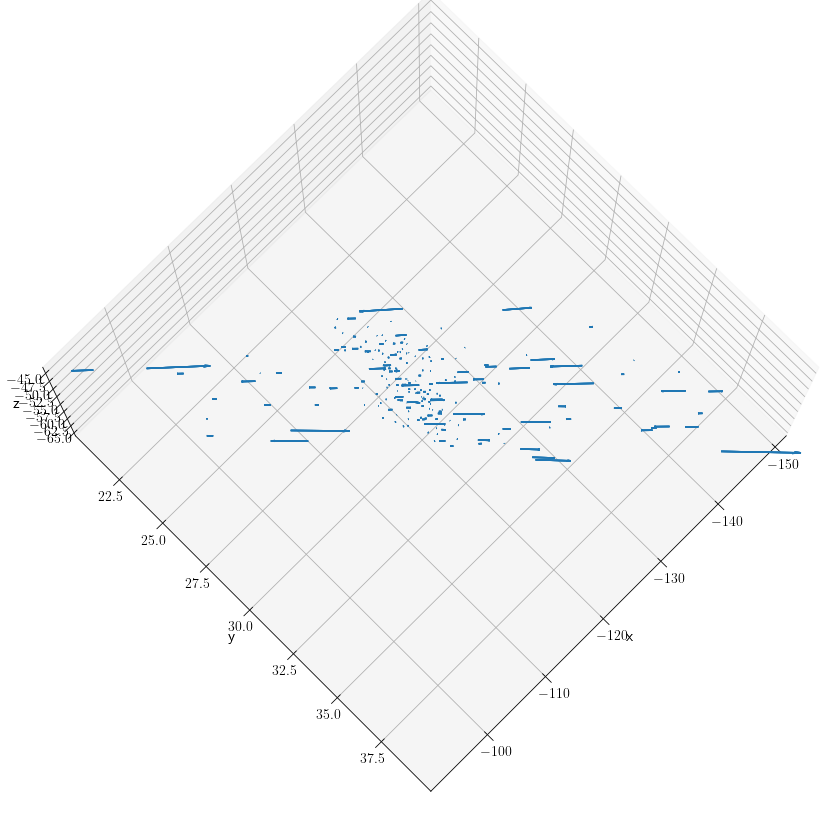

In [20]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')
for i in range(5):
    ax.view_init(0+20*i, 45)
    ax.quiver(data_cart['x'], data_cart['y'], data_cart['z'], data_cart['vx'], data_cart['vy'], data_cart['vz'],
             arrow_length_ratio=0.1)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    
    fig.savefig(f'./{i}', format='pdf')

#plt.show()


In [36]:
dist = data_cart['x']**2 + data_cart['y']**2 + data_cart['z']**2
dist = np.sqrt(dist)

(array([ 1.,  0.,  2.,  2.,  1.,  0.,  1.,  3.,  2.,  1.,  1.,  2.,  3.,
         5., 27., 54., 39., 27.,  9.,  6.,  3.,  4.,  2.,  3.,  1.,  3.,
         3.,  2.,  2.,  1.,  2.,  4.]),
 array([106.13903961, 107.97875718, 109.81847475, 111.65819232,
        113.49790989, 115.33762746, 117.17734503, 119.0170626 ,
        120.85678017, 122.69649774, 124.53621531, 126.37593288,
        128.21565045, 130.05536802, 131.89508559, 133.73480316,
        135.57452073, 137.4142383 , 139.25395587, 141.09367344,
        142.93339101, 144.77310859, 146.61282616, 148.45254373,
        150.2922613 , 152.13197887, 153.97169644, 155.81141401,
        157.65113158, 159.49084915, 161.33056672, 163.17028429,
        165.01000186]),
 <BarContainer object of 32 artists>)

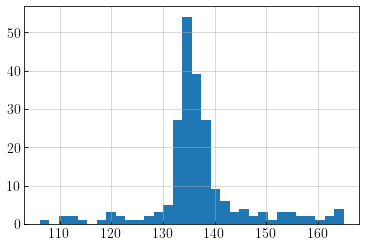

In [38]:
fig2 = plt.figure()
ax = fig2.gca()
ax.hist(dist, bins=32)

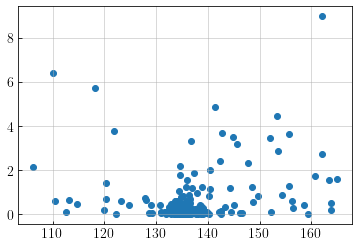

In [39]:
fig3 = plt.figure()
ax = fig3.gca()
ax.scatter(dist, v)

# BELOW HERE NOT UPDATED

## Pleiades

In [2]:
data_path = Path(os.getcwd()).joinpath('data/pleiades-kin+phot.csv')
outpath = Path(os.getcwd()).joinpath('data/pleiades.txt')

# data from SIMBAD - Pleiades
expected = {'ra': 56.6010,
            'dec': +24.1140,
            'l': 166.4628,
            'b': -23.6146,
            'pmra': 19.997,
            'pmdec': -45.548,
            'v_rad': 6.57,
            'plx': 7.364,
            'g_mag': None,
            'bp_rp': None}

plot_title = data_path.parts[-1]
plot_title = plot_title.strip('.csv')
plot_title = plot_title.strip('_gal')
plot_title = plot_title.strip('gaia')

In [4]:
#std = np.array([0.5, .7, 0.5,
#                dataset_pleiades['pml_star'].std(), dataset_pleiades['pmb'].std(), 5,
#                2, 0.4])
std = None
dataset_pleiades, bounds_pleiades, prior_pleiades, mix_pleiades, density_pleiades = dpgmm(outpath,
                                                                                          #outpath=outpath,
                                                                                          convert=False,
                                                                                          std=std,
                                                                                          epsilon=1e-3)

In [5]:
dataset_pleiades.as_array().shape

(1178, 8)

In [6]:
N_stars = dataset_pleiades.as_array().shape[0]

In [7]:
density_pleiades.n_cl

656

### Plot

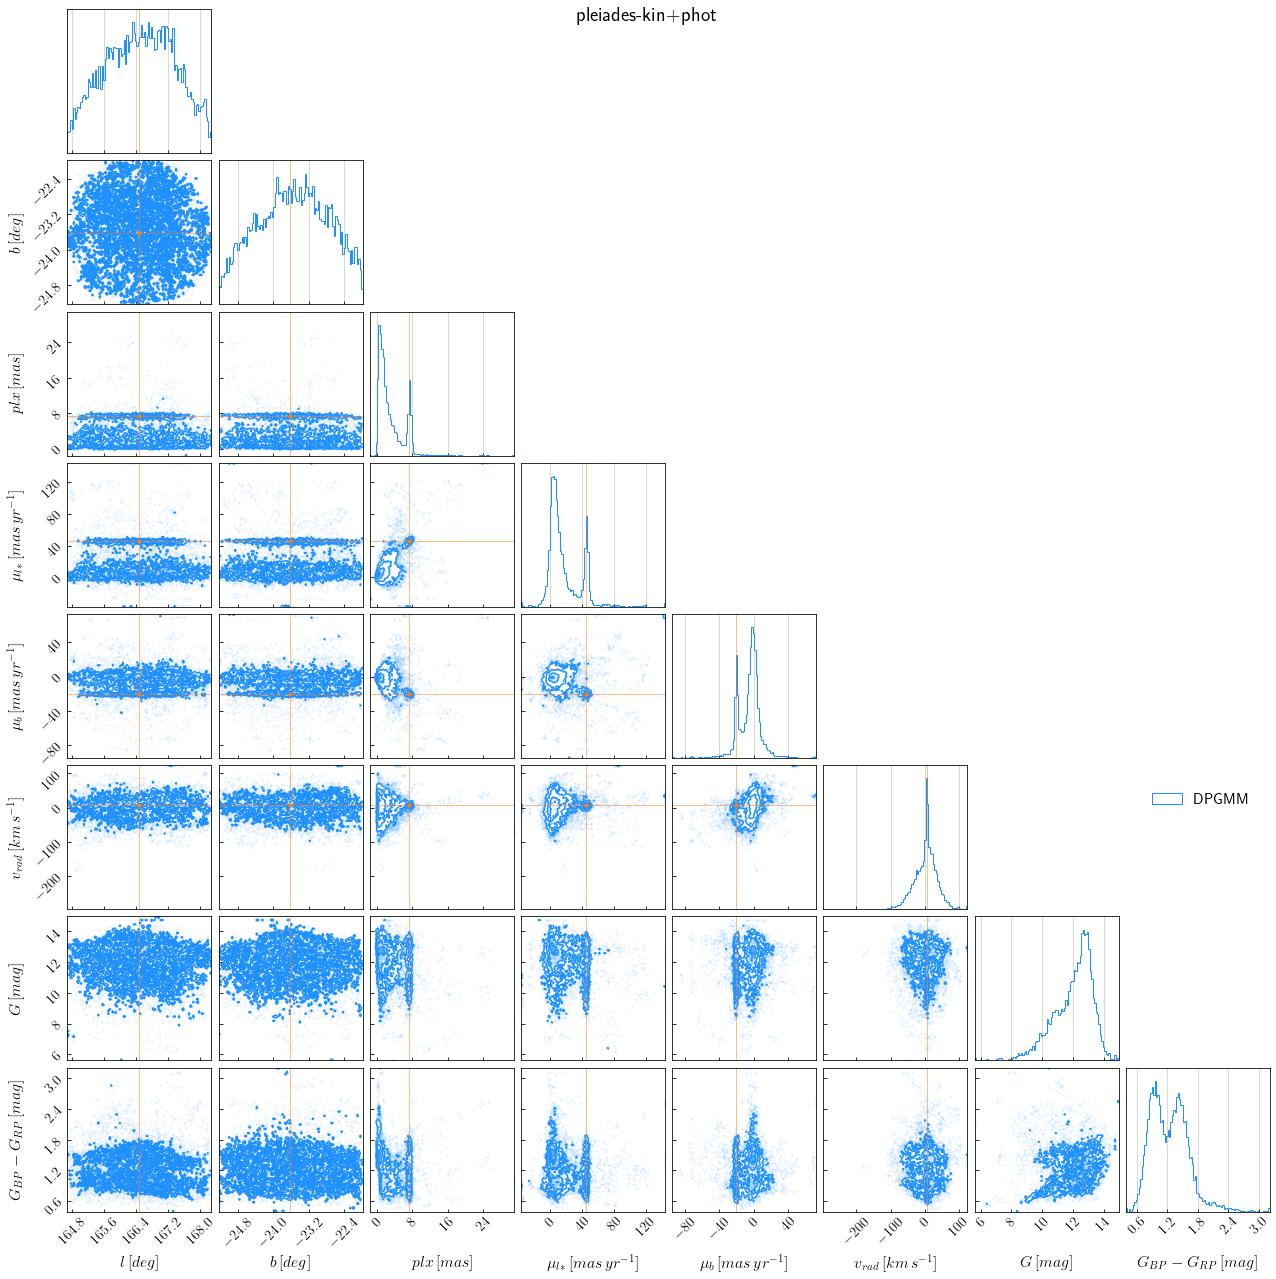

In [9]:
cp = CornerPlot(density=density_pleiades,
                dataset=dataset_pleiades,
                expected=expected)
fig = cp(n_alot, plot_title=plot_title)
plt.show()

## M4

In [11]:
data_path = Path(os.getcwd()).joinpath('data/M4-kin+phot.csv')
outpath = Path(os.getcwd()).joinpath('data/M4.txt')

# data from SIMBAD - M4
expected = {'ra': 245.89675,
            'dec': -26.52575,
            'l': 350.97293,
            'b': +15.97218,
            'pmra': -12.48,
            'pmdec': -18.99,
            'v_rad': 71.05,
            'plx': 0.556,
            'g_mag': None,
            'bp_rp': None}

plot_title = data_path.parts[-1]
plot_title = plot_title.strip('.csv')
plot_title = plot_title.strip('_gal')
plot_title = plot_title.strip('gaia')

In [12]:
std = None
dataset_m4, bounds_m4, prior_m4, mix_m4, density_m4 = dpgmm(outpath,
                                                            #outpath=outpath,
                                                            convert=False,
                                                            std=std,
                                                            epsilon=1e-3)

In [13]:
dataset_m4.as_array().shape

(269, 8)

In [14]:
N_stars = dataset_m4.as_array().shape[0]

In [15]:
density_m4.n_cl

85

### Plot

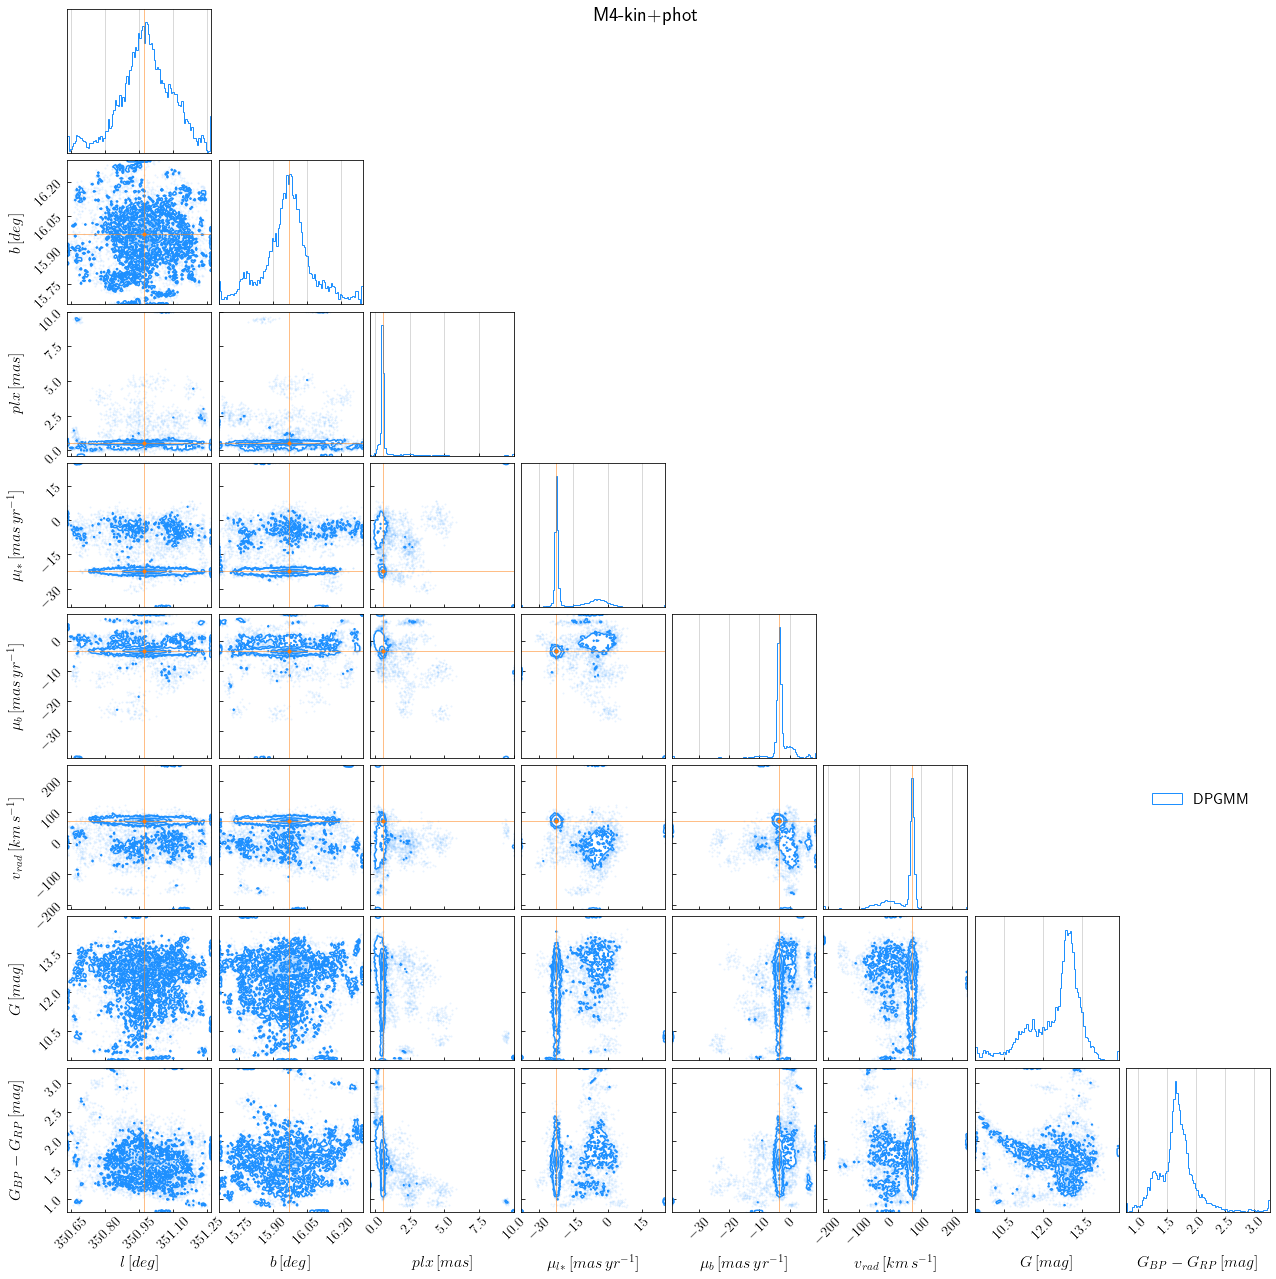

In [16]:
cp = CornerPlot(density=density_m4,
                dataset=dataset_m4,
                expected=expected)
fig = cp(n_alot, plot_title=plot_title)
plt.show()

## Omega Centauri

In [18]:
data_path = Path(os.getcwd()).joinpath('data/OmegaCen-kin+phot.csv')
outpath = Path(os.getcwd()).joinpath('data/OmegaCen.txt')

# data from SIMBAD - OmegaCen
expected = {'ra': 201.69700,
            'dec': -47.47947,
            'l': 309.10202,
            'b': +14.96833,
            'pmra': -3.24,
            'pmdec': -6.73,
            'v_rad': 234.28,
            'plx': 0.193,
            'g_mag': None,
            'bp_rp': None}

plot_title = data_path.parts[-1]
plot_title = plot_title.strip('.csv')
plot_title = plot_title.strip('_gal')
plot_title = plot_title.strip('gaia')

In [19]:
std = None
dataset_oc, bounds_oc, prior_oc, mix_oc, density_oc = dpgmm(outpath,
                                                            #outpath=outpath,
                                                            convert=False,
                                                            std=std,
                                                            epsilon=1e-3)

In [20]:
dataset_oc.as_array().shape

(521, 8)

In [21]:
N_stars = dataset_oc.as_array().shape[0]

### Plot

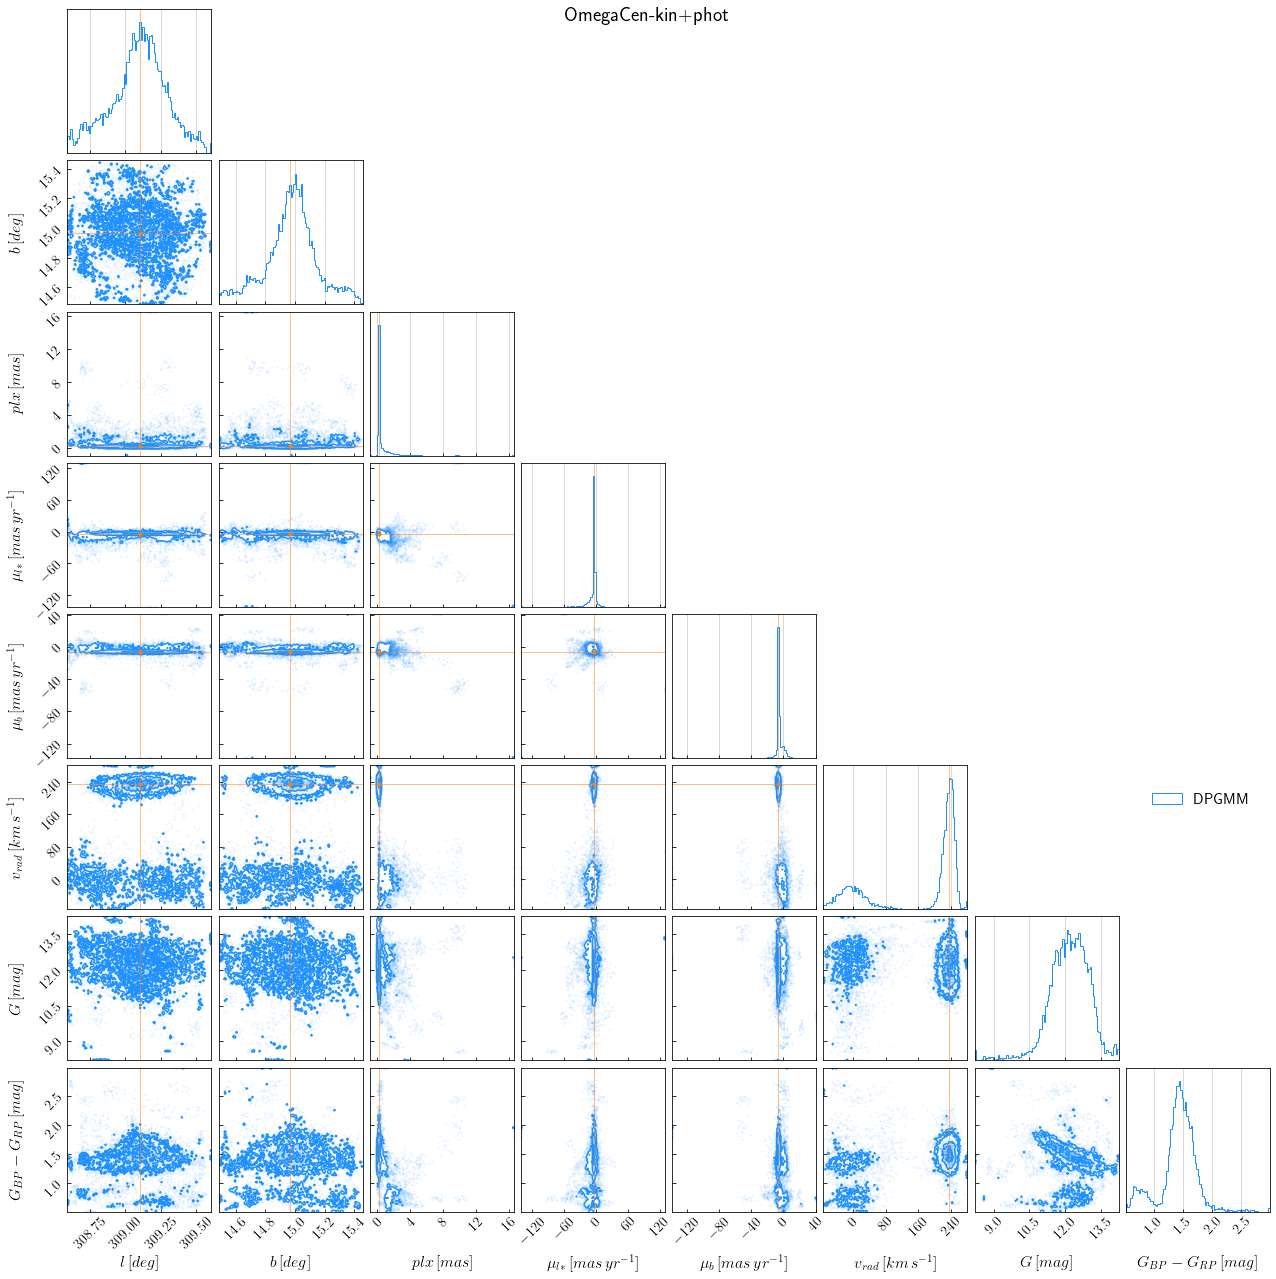

In [22]:
cp = CornerPlot(density=density_oc,
                dataset=dataset_oc,
                expected=expected)
fig = cp(n_alot, plot_title=plot_title)
plt.show()

## NGC2516

In [24]:
data_path = Path(os.getcwd()).joinpath('data/ngc2516-kin+phot.csv')
outpath = Path(os.getcwd()).joinpath('data/ngc2516.txt')

# data from SIMBAD
expected = {'ra': 119.5270,
            'dec': -60.8000,
            'l': 273.8612,
            'b': -15.8730,
            'pmra': -4.6579,
            'pmdec': 11.1517,
            'v_rad': 24.2,
            'plx': 2.4118,
            'g_mag': None,
            'bp_rp': None}

plot_title = data_path.parts[-1]
plot_title = plot_title.strip('.csv')
plot_title = plot_title.strip('_gal')
plot_title = plot_title.strip('gaia')

In [26]:
std = None
dataset_ngc2516, bounds_ngc2516, prior_ngc2516, mix_ngc2516, density_ngc2516 = dpgmm(outpath,
                                                                                     #outpath=outpath,
                                                                                     convert=False,
                                                                                     std=std,
                                                                                     epsilon=1e-3)

In [27]:
dataset_ngc2516.as_array().shape

(837, 8)

In [28]:
N_stars = dataset_ngc2516.as_array().shape[0]

### Plot

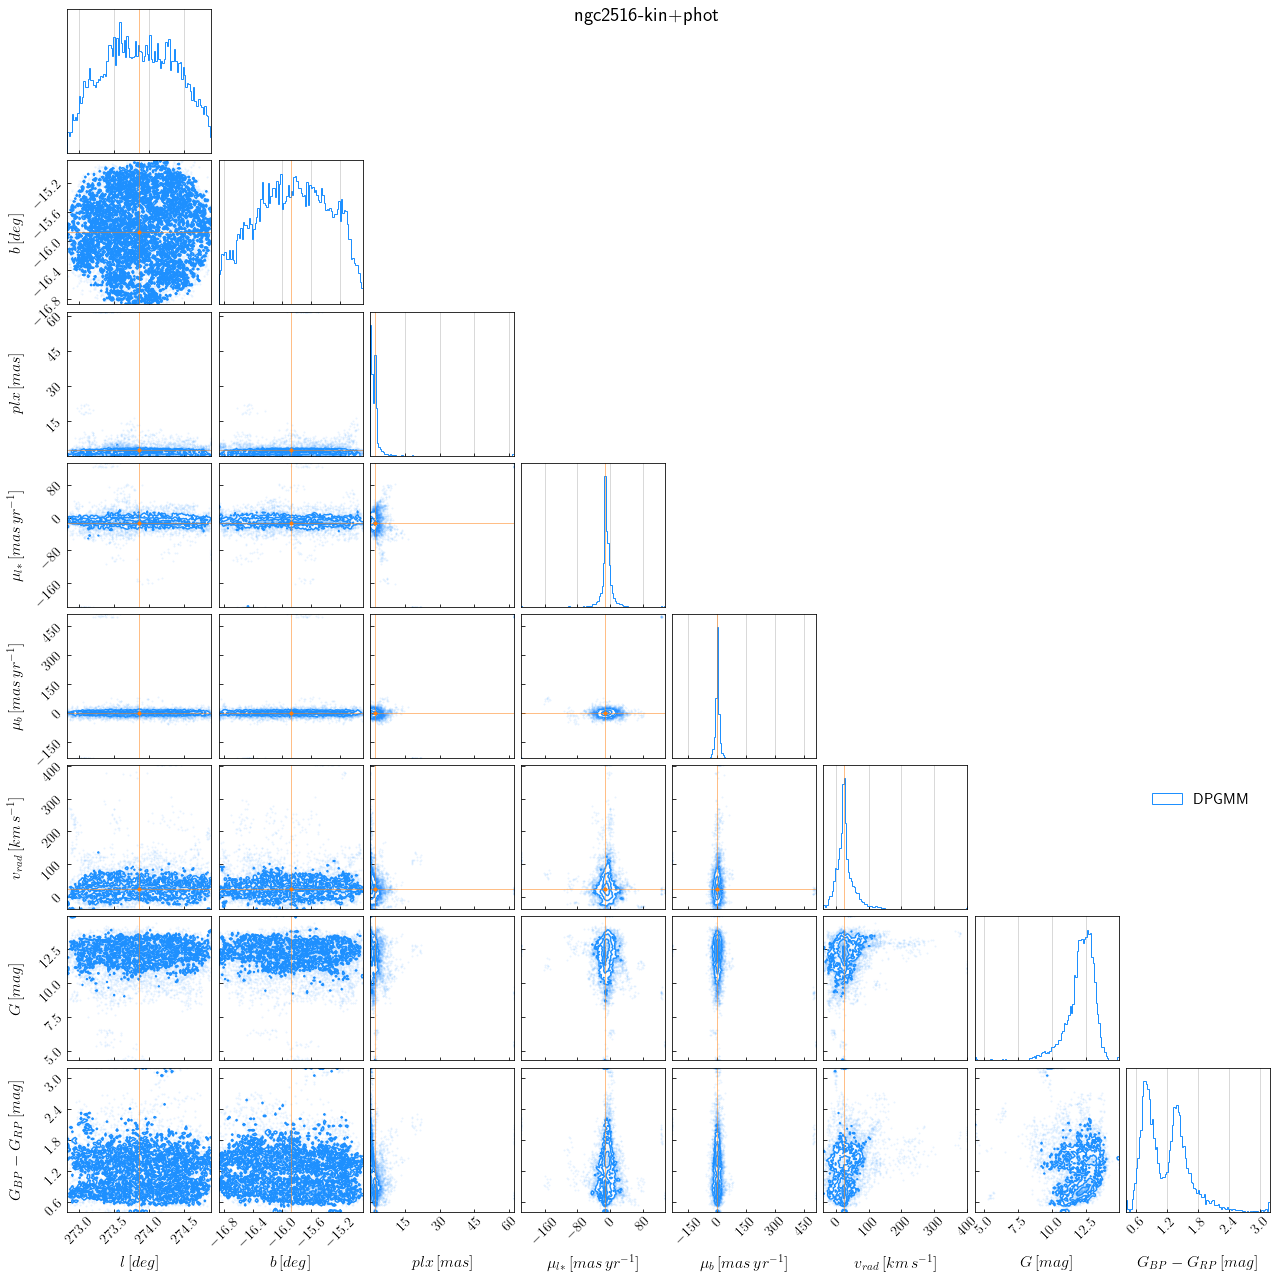

In [29]:
cp = CornerPlot(density=density_ngc2516,
                dataset=dataset_ngc2516,
                expected=expected)
fig = cp(n_alot, plot_title=plot_title)
plt.show()

In [30]:
fig.savefig(f'ngc2516-kin+phot-{n_alot}.pdf', format='pdf')